# Clustering de documents

In [ ]:
# TP3
# copie de s2_clustering du module4

## Imports

In [1]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [2]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yaeld\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data_path = "../data/txt/"

## Choisir une décennie

In [4]:
DECADE = '1950'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [5]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [7]:
# Exemple de fichiers
files[:5]

['KB_JB838_1950-01-06_01-00002.txt',
 'KB_JB838_1950-01-07_01-00013.txt',
 'KB_JB838_1950-01-08_01-00011.txt',
 'KB_JB838_1950-01-10_01-00006.txt',
 'KB_JB838_1950-01-15_01-00010.txt']

In [6]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [7]:
# Exemple de textes
texts[0][:400]

'/ LE SOIR Une importante manifestation franco-belge Le Comité franco-belge du Commerce, de l’Industrie et de l’Agriculture qui. au cours de l’année écoulée et dans les circonstances les plus difficiles a rendu aux relations économiques entre les deux pays des services considérables, donnera le 12 janvier, à 19 h. 30, un dîner à l’occasion de l’anniversaire de son installation. Ce comité, qui fonct'

## Vectoriser les documents à l'aide de TF-IDF

In [9]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [10]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [11]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [12]:
# Détail de la matrice
tfidf_vectors.shape

(1000, 3508)

### Imprimer le vecteur tf-IDF du premier document

In [13]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

parti           0.276899
loyer           0.152155
janvier         0.147985
populaire       0.147400
propriétaire    0.143646
                  ...   
ent             0.000000
entend          0.000000
enthousiasme    0.000000
entier          0.000000
italiens        0.000000
Length: 3508, dtype: float64

## Comprendre les vecteurs et leurs "distances"

### Tests sur nos documents

In [14]:
tfidf_array = tfidf_vectors.toarray()

In [15]:
# Vecteur du document 0
tfidf_array[0]

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.03783208])

In [16]:
# Vecteur du document 1
tfidf_array[1]

array([0.        , 0.00670198, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [17]:
cosine(tfidf_array[0], tfidf_array[1])

0.931459087039414

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [26]:
N_CLUSTERS = 4

### Instancier le modèle K-Means et ses arguments

In [27]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [28]:
clusters = km_model.fit_predict(tfidf_vectors)

In [29]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [30]:
pprint(dict(clustering))

{0: ['KB_JB838_1950-01-08_01-00011.txt',
     'KB_JB838_1950-03-29_01-00008.txt',
     'KB_JB838_1950-04-21_01-00010.txt',
     'KB_JB838_1950-05-20_01-00016.txt',
     'KB_JB838_1950-06-04_01-00012.txt',
     'KB_JB838_1950-06-24_01-00011.txt',
     'KB_JB838_1950-06-25_01-00013.txt',
     'KB_JB838_1950-07-08_01-00009.txt',
     'KB_JB838_1950-07-20_01-00010.txt',
     'KB_JB838_1950-09-21_01-00009.txt',
     'KB_JB838_1950-10-15_01-00016.txt',
     'KB_JB838_1950-11-04_01-00012.txt',
     'KB_JB838_1950-11-09_01-00012.txt',
     'KB_JB838_1950-12-14_01-00011.txt',
     'KB_JB838_1951-01-04_01-00009.txt',
     'KB_JB838_1951-01-13_01-00012.txt',
     'KB_JB838_1951-01-23_01-00009.txt',
     'KB_JB838_1951-01-25_01-00010.txt',
     'KB_JB838_1951-02-03_01-00013.txt',
     'KB_JB838_1951-02-14_01-00009.txt',
     'KB_JB838_1951-02-24_01-00011.txt',
     'KB_JB838_1951-03-06_01-00010.txt',
     'KB_JB838_1951-04-11_01-00010.txt',
     'KB_JB838_1951-05-13_01-00015.txt',
     'KB_JB838_1

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [31]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [32]:
reduced_vectors[:10]

array([[-0.32605256,  0.11352981],
       [ 0.11443706, -0.30121581],
       [ 0.44374749, -0.251834  ],
       [-0.2392338 , -0.03685966],
       [-0.05219372, -0.1041351 ],
       [ 0.61193695,  0.50552469],
       [-0.20445202, -0.03419623],
       [-0.19508296, -0.03696588],
       [ 0.62322593,  0.45733878],
       [ 0.15728827, -0.01517594]])

### Générer le plot

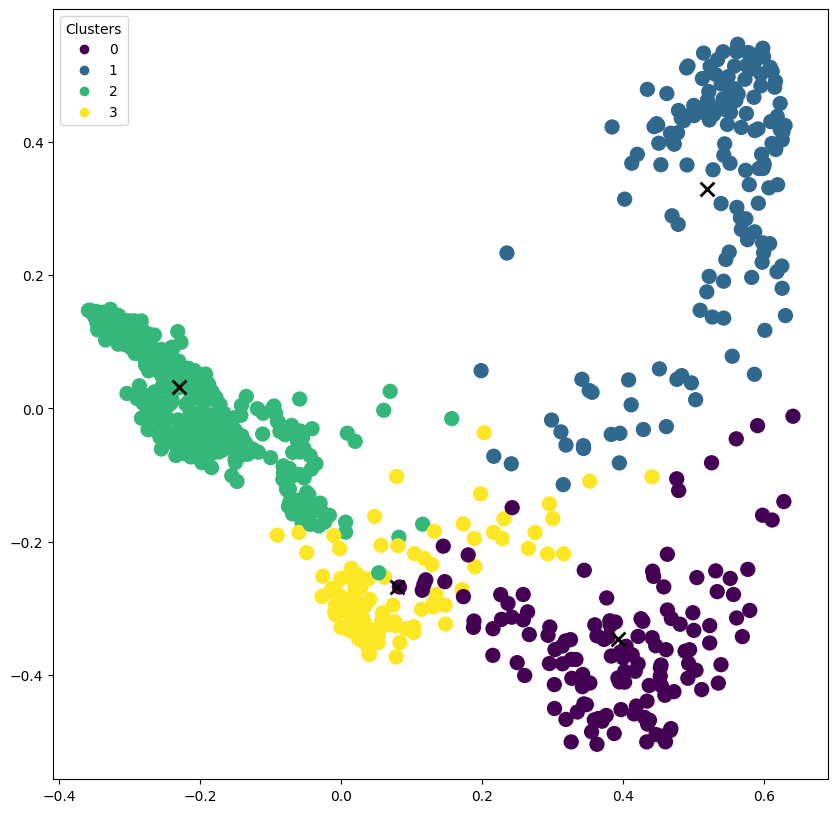

In [33]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

# Word Embeddings : le modèle Word2Vec

## Imports

In [34]:
import sys

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

## Chargement et traitement des phrases du corpus

### Création d'un objet qui *streame* les lignes d'un fichier pour économiser de la RAM

In [35]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [36]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

### Détection des bigrammes



In [37]:
bigram_phrases = Phrases(sentences)

In [38]:
type(bigram_phrases.vocab)

dict

In [39]:
len(bigram_phrases.vocab.keys())

15850647

Prenons une clé au hasard :

In [41]:
key_ = list(bigram_phrases.vocab.keys())[320]
print(key_)

terre


Le dictionnaire indique le score de cette coocurrence :

In [42]:
bigram_phrases.vocab[key_]

22525

### Conversion des `Phrases` en objet `Phraser`



In [43]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

### Extraction des trigrams

In [44]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [45]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

In [46]:
trigram_phrases = Phrases(bigram_phraser[sentences])

### Création d'un corpus d'unigrams, bigrams, trigrams

In [47]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

In [48]:
print(corpus[:100])

[['mi', 'imnri', 'r', 'i', '<<', 'i', 'i', 'hmu', "'", 'i', '/', 'tx', "-'", 'l', ':', 'marche', 'tenu', 'hors', 'villa', ',', 'la', '9', '.'], ['--', 'u', 'a', 'ete', 'vaain', 'si', 'teicj', '>>', 'm', 'races_indigenes', 'de', 'fr', '.'], ['31', '<)', 'a', '5s', "'", 'k', '131', 'de', '.'], ['rasa', 'iichakdui', "'", 'te', ',', 'do', '(', 'r', '.', '3s0', 'h', '710', '.', 'taureaux', 'iallsenas', ',>', 'ia', 'u', '\\', '--', 'a', '--', ';', '0ii', '.'], ['hollandais', ',', 'dufr', '.'], ['0', '.'], ['--', 'a', '9', '.--', 'la', 'idto', '-', 'vachei', 'laitieres', ':', 'bn', 'vante', '1q', '.'], ['vendues', '3', '\\', 'au', 'prix', 'la', '410', 'a', '*', '<<', 'i', 'h', '\\;', 'genisses', ',', 'kl', '.'], ["'.", '9', '.'], ['i', 'l', '.', '2', 'i', '.', 'id', '.'], ['da', '370', 'i', '6lutr', '.'], ['marche', 'a', '<', 'u', 'porcs', '.'], ['--', 'categorie', 'de', 'lt', 'ilashtya', ':', "'", '237', 'on', 'vente', ';', 'vendus', '1', 'm', '.', 'do', "'", '2', 'i', '.--', 'a', ';:,', 'l'

## Entrainement d'un modèle Word2Vec sur ce corpus

In [49]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=5, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.
)

CPU times: total: 19min 50s
Wall time: 8min 5s


### Sauver le modèle dans un fichier

In [50]:
outfile = f"../data/newspapers.model"
model.save(outfile)

## Explorer le modèle

In [51]:
model = Word2Vec.load("../data/newspapers.model")

In [52]:
model.wv["parti"]

array([ 2.2247555 ,  0.6819363 , -0.46982887, -1.4887618 , -4.667383  ,
       -4.239567  , -1.700415  ,  0.7355679 , -5.223171  ,  2.490132  ,
        0.06175804,  2.2967103 ,  1.475354  , -2.5924861 ,  1.302314  ,
       -1.7824819 , -1.58623   , -2.389655  , -0.8751696 , -4.3609824 ,
        0.7371284 , -0.7916897 ,  2.7633612 ,  1.1216733 , -0.9692526 ,
       -0.95085186,  3.9775462 , -1.6057857 ,  0.2804738 , -6.893184  ,
       -2.3377616 , -2.2372403 ], dtype=float32)

In [53]:
model.wv.similarity("parti", "gouvernement")

0.82142437

In [54]:
model.wv.similarity("fleur", "gouvernement")

-0.2098843

In [55]:
model.wv.similarity("cigarette", "cancer")

0.13332462

### Chercher les mots les plus proches d'un terme donné

In [56]:
model.wv.most_similar("parti", topn=10)

[('parti_travailliste', 0.8567697405815125),
 ('parti_socialiste', 0.8449087738990784),
 ('compromis', 0.8379006385803223),
 ('reich', 0.8356797695159912),
 ('differend', 0.8324472904205322),
 ('front_populaire', 0.8244948387145996),
 ('gouvernement', 0.8214244246482849),
 ('parti_liberal', 0.8187993168830872),
 ('conflit', 0.8177098631858826),
 ('fait_accompli', 0.8156004548072815)]

In [57]:
model.wv.most_similar("gouvernement", topn=10)

[('gouvernement_francais', 0.9530786275863647),
 ('gouvernement_britannique', 0.9518114924430847),
 ('gouvernement_allemand', 0.9372742176055908),
 ('gouvernement_italien', 0.9263112545013428),
 ('gouvernement_belge', 0.9254562854766846),
 ('gouvernement_americain', 0.9225295782089233),
 ('reich', 0.9108985662460327),
 ('parlement', 0.9082010388374329),
 ('gouvernement_anglais', 0.9079968333244324),
 ('principe', 0.9068506956100464)]

In [58]:
model.wv.most_similar("fleur", topn=10)

[('mousse', 0.8876544237136841),
 ('moelle', 0.8738970160484314),
 ('tomate', 0.8726286888122559),
 ('racine', 0.8707342743873596),
 ('noix', 0.868889331817627),
 ('sauce', 0.868702232837677),
 ('tortue', 0.8686245083808899),
 ('truite', 0.8642770051956177),
 ('moustache', 0.8631142973899841),
 ('chair', 0.8620525002479553)]

In [59]:
model.wv.most_similar("cigarette", topn=10)

[('vache', 0.9190967679023743),
 ('coquille', 0.8857174515724182),
 ('bouteille', 0.8768215775489807),
 ('fourchette', 0.8722811341285706),
 ('torche', 0.8654356002807617),
 ('canne', 0.863666296005249),
 ('baleine', 0.8556278944015503),
 ('perruque', 0.8495801687240601),
 ('ficelle', 0.8490378856658936),
 ('brosse', 0.8489136099815369)]

In [60]:
model.wv.most_similar("cancer", topn=10)

[('bacille', 0.7994846105575562),
 ('liberalisme', 0.7981981039047241),
 ('salariat', 0.7857577800750732),
 ('bolchevisme', 0.783255934715271),
 ('communisme', 0.7791157364845276),
 ('cholera', 0.775962233543396),
 ('pentagone', 0.7744441628456116),
 ('rearmement_allemand', 0.7722188830375671),
 ('probleme_allemand', 0.7696313261985779),
 ('federalisme', 0.7695887088775635)]